In [ ]:
#default_exp interpret.interpret

# Analyse Model Confidence

This module extends fastai's [`ClassificationInterpretation`](https://dev.fast.ai/interpret) class to analyse the degree of confidence with which the model makes its predictions. <br>

All results are stored as attributes of the `ClassificationInterpretationEx` object as `DataFrame`s for further analysis, if needed.

<br>
<br>

In [ ]:
#hide
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
#export
from fastai2.vision.all import *
from fastai2.metrics import *
from nbdev.showdoc import show_doc

In [ ]:
#hide
path_data = Path('/Users/rahulsomani/Desktop/shot-lighting-cast')

dls = ImageDataLoaders.from_folder(path_data/'train', valid_pct=0.03, seed=42,
                                   item_tfms = Resize(size=224, method=ResizeMethod.Squish))

class ApplyPILFilter(RandTransform):pass
learn = load_learner(path_data/'fastai2-110-epoch-model.pkl');
learn.dls = dls


/Users/rahulsomani/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/rahulsomani/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/rahulsomani/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by 

For some context, the model I'm using here is a single-label classifier with a softmax activation, and has two classes:
1. `shot_lighting_cast_hard`
2. `shot_lighting_cast_soft`

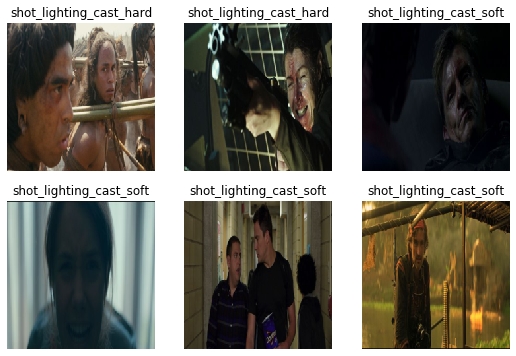

In [ ]:
learn.dls.show_batch(max_n=6)

In [ ]:
#export
class ClassificationInterpretationEx(ClassificationInterpretation):
    """
    Extend fastai2's `ClassificationInterpretation` to analyse model predictions in more depth
    """
    def __init__(self, dl, inputs, preds, targs, decoded, losses):
        store_attr(self, "dl,inputs,preds,targs,decoded,losses")
    
    def compute_label_confidence(self):
        """
        Collate prediction confidence, filenames, and ground truth labels
        in DataFrames, and store them as class attributes
        `self.preds_df` and `self.preds_df_each`
        """
        self._preds_collated = [
            (item, self.dl.vocab[label_idx], *preds.numpy()*100)\
            for item,label_idx,preds in zip(self.dl.items,
                                            self.targs,
                                            self.preds)
        ]

        self.preds_df       = pd.DataFrame(self._preds_collated, columns = ['fname','truth', *self.dl.vocab])
        self._preds_df_each = {l:self.preds_df.copy()[self.preds_df.truth == l].reset_index(drop=True) for l in self.dl.vocab}
        self.preds_df_each  = defaultdict(dict)


        sort_desc = lambda x,col: x.sort_values(col, ascending=False).reset_index(drop=True)
        for label,df in self._preds_df_each.items():
            filt = df[label] == df[self.dl.vocab].max(axis=1)
            self.preds_df_each[label]['accurate']   = df.copy()[filt]
            self.preds_df_each[label]['inaccurate'] = df.copy()[~filt]
            
            self.preds_df_each[label]['accurate']   = sort_desc(self.preds_df_each[label]['accurate'], label)
            self.preds_df_each[label]['inaccurate'] = sort_desc(self.preds_df_each[label]['inaccurate'], label)
            assert len(self.preds_df_each[label]['accurate']) + len(self.preds_df_each[label]['inaccurate']) == len(df)
    
    def plot_label_confidence(self, bins=10, fig_width=12, fig_height_base=4, return_fig=False,
                              title='Accurate vs. Inaccurate Predictions Confidence (%) Levels Per Label',
                              accurate_color='mediumseagreen', inaccurate_color='tomato'):
        'Plot label confidence histograms for each label'
        if not hasattr(self, 'preds_df_each'): self.compute_label_confidence()
        fig, axes = plt.subplots(nrows = len(self.preds_df_each.keys()), ncols=2,
                                 figsize = (fig_width, fig_height_base * len(self.dl.vocab)))
        for i, (label, df) in enumerate(self.preds_df_each.items()):
            for mode,ax in zip(['inaccurate', 'accurate'], axes[i]):
                range_ = (50,100) if mode == 'accurate' else (0,50)
                color  = accurate_color if mode == 'accurate' else inaccurate_color
                ax.hist(df[mode][label], bins=bins, range=range_, rwidth=.95, color=color)
                ax.set_xlabel(f'{label}: {mode.capitalize()}')
                ax.set_ylabel(f'No. {mode.capitalize()} = {len(df[mode][label])}')
        fig.suptitle(title)
        plt.subplots_adjust(top = 0.9, bottom=0.01, hspace=0.25, wspace=0.2)
        if return_fig: return fig
        
        
    def plot_accuracy(self, width=0.5, figsize=(6,6), return_fig=False,
                      title='Accuracy Per Label', ylabel='Accuracy (%)',
                      color='steelblue', vertical_labels=False):
        'Plot a bar plot showing accuracy per label'
        if not hasattr(self, 'preds_df_each'): self.compute_label_confidence()
        self.accuracy_dict = defaultdict()
        
        for label,df in self.preds_df_each.items():
            total = len(df['accurate']) + len(df['inaccurate'])
            self.accuracy_dict[label] = 100 * len(df['accurate']) / total
        
        fig,ax = plt.subplots(figsize=figsize)
        
        x = self.accuracy_dict.keys()
        y = [v for k,v in self.accuracy_dict.items()]
        
        rects = ax.bar(x,y,width,color=color)
        for rect in rects:
            ht = rect.get_height()
            ax.annotate(s  = f"{ht:.02f}",
                        xy = (rect.get_x() + rect.get_width()/2, ht),
                        xytext = (0,3), # offset vertically by 3 points
                        textcoords = 'offset points',
                        ha = 'center', va = 'bottom'
                       )
        ax.set_ybound(lower=0, upper=100)
        ax.set_yticks(np.arange(0,110,10))
        ax.set_ylabel(ylabel)
        ax.set_xticklabels(x, rotation='vertical' if vertical_labels else 'horizontal')
        plt.suptitle(title)
        if return_fig: return fig
        
    def get_fnames(self, label:str,
                   mode:('accurate','inaccurate'),
                   conf_level:Union[int,float,tuple]) -> np.ndarray:
        """
        Utility function to grab filenames of a particular label `label` that were classified
        as per `mode` (accurate|inaccurate).
        These filenames are filtered by `conf_level` which can be above or below a certain
        threshold (above if `mode` == 'accurate' else below), or in confidence ranges
        """
        assert label in self.dl.vocab
        if not hasattr(self, 'preds_df_each'): self.compute_label_confidence()
        df = self.preds_df_each[label][mode].copy()
        if mode == 'accurate':
            if isinstance(conf_level, tuple):       filt = df[label].between(*conf_level)
            if isinstance(conf_level, (int,float)): filt = df[label] > conf_level
        if mode == 'inaccurate':
            if isinstance(conf_level, tuple):       filt = df[label].between(*conf_level)
            if isinstance(conf_level, (int,float)): filt = df[label] < conf_level
        return df[filt].fname.values

In [ ]:
interp = ClassificationInterpretationEx.from_learner(learn)

In [ ]:
show_doc(ClassificationInterpretationEx.compute_label_confidence)

<h4 id="ClassificationInterpretationEx.compute_label_confidence" class="doc_header"><code>ClassificationInterpretationEx.compute_label_confidence</code><a href="__main__.py#L9" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationInterpretationEx.compute_label_confidence</code>()

```
Collate prediction confidence, filenames, and ground truth labels
in DataFrames, and store them as class attributes
`self.preds_df` and `self.preds_df_each`
```

`self.preds_df` has (2 + num. labels) columns. <br>
1. `fname` has the path to the file on disk <br>
2. `truth` has the ground truth <br>
3. The third column onwards contain label confidence for each label (in %)

In [ ]:
interp.compute_label_confidence()

In [ ]:
interp.preds_df.head()

,fname,truth,shot_lighting_cast_hard,shot_lighting_cast_soft
0,/Users/rahulsomani/Desktop/shot-lighting-cast/train/shot_lighting_cast_soft/avatar__2009__157_cropped.jpg,shot_lighting_cast_soft,11.213491,88.786507
1,/Users/rahulsomani/Desktop/shot-lighting-cast/train/shot_lighting_cast_soft/almost_famous__2000__019_cropped.jpg,shot_lighting_cast_soft,31.573517,68.426483
2,/Users/rahulsomani/Desktop/shot-lighting-cast/train/shot_lighting_cast_hard/big_fish__2003__048_cropped.jpg,shot_lighting_cast_hard,17.304955,82.695045
3,/Users/rahulsomani/Desktop/shot-lighting-cast/train/shot_lighting_cast_hard/adventures_of_tintin__the__2011__041_cropped.jpg,shot_lighting_cast_hard,55.695004,44.304996
4,/Users/rahulsomani/Desktop/shot-lighting-cast/train/shot_lighting_cast_hard/8___1963__222_cropped.jpg,shot_lighting_cast_hard,50.986187,49.013813


`self.preds_df_each` is a two-level dictionary.

The keys at the first level are the names of the labels (`self.dl.vocab`) <br>
The second level has two keys -- `'accurate'` and `'inaccurate'`, both of which <br>
store `pd.DataFrame`s sorted in descending order of label confidence

This allows you to quickly find the location to the files based on confidence, and you can easily save these to disk for more detailed perusal and to gain insights on where your model fails

In [ ]:
assert interp.dl.vocab == interp.preds_df_each.keys()

In [ ]:
interp.preds_df_each['shot_lighting_cast_hard']['accurate'].head(3)

,fname,truth,shot_lighting_cast_hard,shot_lighting_cast_soft
0,/Users/rahulsomani/Desktop/shot-lighting-cast/train/shot_lighting_cast_hard/avatar__2009__075_cropped.jpg,shot_lighting_cast_hard,84.131889,15.868108
1,/Users/rahulsomani/Desktop/shot-lighting-cast/train/shot_lighting_cast_hard/8___1963__045_cropped.jpg,shot_lighting_cast_hard,83.481560,16.518444
2,/Users/rahulsomani/Desktop/shot-lighting-cast/train/shot_lighting_cast_hard/accountant__the__2016__011_cropped.jpg,shot_lighting_cast_hard,77.070702,22.929298


---

In [ ]:
show_doc(ClassificationInterpretationEx.get_fnames)

<h4 id="ClassificationInterpretationEx.get_fnames" class="doc_header"><code>ClassificationInterpretationEx.get_fnames</code><a href="__main__.py#L78" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationInterpretationEx.get_fnames</code>(**`label`**:`str`, **`mode`**:`('accurate', 'inaccurate')`, **`conf_level`**:`Union`\[`int`, `float`, `tuple`\])

```
Utility function to grab filenames of a particular label `label` that were classified
as per `mode` (accurate|inaccurate).
These filenames are filtered by `conf_level` which can be above or below a certain
threshold (above if `mode` == 'accurate' else below), or in confidence ranges
```

In [ ]:
# return accuratly classified files with accuracy above 85%
interp.get_fnames('shot_lighting_cast_hard', 'accurate', 85)

array([], dtype=object)

In [ ]:
# return inaccurately classified files with accuracy between 84.1 - 85.2%
interp.get_fnames('shot_lighting_cast_hard', 'accurate', (84.1, 85.2))

array([Path('/Users/rahulsomani/Desktop/shot-lighting-cast/train/shot_lighting_cast_hard/avatar__2009__075_cropped.jpg')],
      dtype=object)

---

In [ ]:
show_doc(ClassificationInterpretationEx.plot_accuracy)

<h4 id="ClassificationInterpretationEx.plot_accuracy" class="doc_header"><code>ClassificationInterpretationEx.plot_accuracy</code><a href="__main__.py#L56" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationInterpretationEx.plot_accuracy</code>(**`width`**=*`0.5`*, **`figsize`**=*`(6, 6)`*, **`return_fig`**=*`False`*, **`title`**=*`'Accuracy Per Label'`*, **`ylabel`**=*`'Accuracy (%)'`*, **`color`**=*`'steelblue'`*)

```
Plot a bar plot showing accuracy per label
```

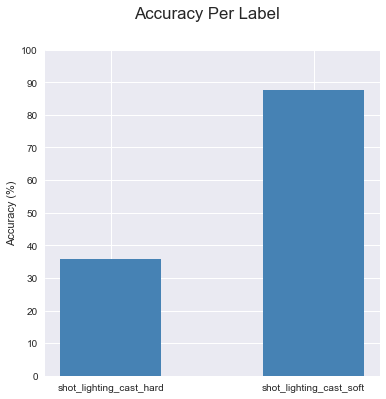

In [ ]:
interp.plot_accuracy()

---

In [ ]:
show_doc(ClassificationInterpretationEx.plot_label_confidence)

<h4 id="ClassificationInterpretationEx.plot_label_confidence" class="doc_header"><code>ClassificationInterpretationEx.plot_label_confidence</code><a href="__main__.py#L37" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationInterpretationEx.plot_label_confidence</code>(**`bins`**=*`10`*, **`fig_width`**=*`12`*, **`fig_height_base`**=*`4`*, **`return_fig`**=*`False`*, **`title`**=*`'Accurate vs. Inaccurate Predictions Confidence (%) Levels Per Label'`*, **`accurate_color`**=*`'mediumseagreen'`*, **`inaccurate_color`**=*`'tomato'`*)

```
Plot label confidence histograms for each label
```

Analysing model prediction confidence can help evaluate the model beyond just a metric. If you have a model where most of it's predictions are with confidence of > 90%, it's safe to say that it's an opinionated one, and has formed a clear representation of the data it's been trained on. Whether or not this representation is any good is, of course, dependent on how you evaluate it.

It would be very interesting if a particular lable had a high accuracy but fairly low confidence scores, or if it had low accuracy, but high confidence scores.

In this particular example, it's clear that the model has a strong opinion of what a 'shot_lighting_cast_soft' image must be, and the opposite for the other label (this is also reflected in the accuracy scores). 

In [ ]:
#hide
plt.style.use('seaborn')
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 14

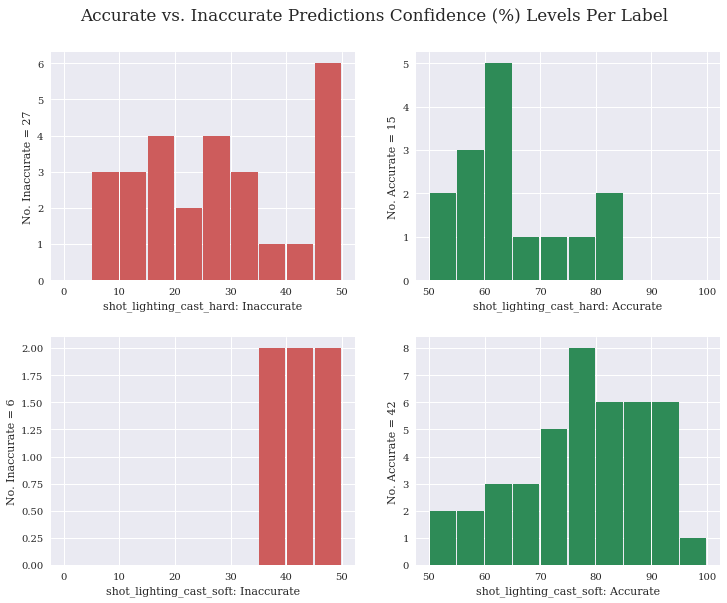

In [ ]:
interp.plot_label_confidence(inaccurate_color = 'indianred',
                             accurate_color   = 'seagreen')

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_classification-interpretation.ipynb.
Converted 02_compare-models.ipynb.
Converted 03_gradcam.ipynb.
Converted 04_export-to-other-frameworks.ipynb.
Converted index.ipynb.
